In [167]:
import numpy as np
#from scipy import stats
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.colors import LogNorm
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

from functools import partial
from scarlet.display import AsinhMapping
#from photutils.psf import extract_stars
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling import rotations
#from photutils import EPSFBuilder
#from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping
from scarlet.display import AsinhMapping
import sep
from functools import partial
#import image_registration
#import pandas as pd
#import pandasql as ps
from matplotlib.colors import LogNorm

from scipy.ndimage.interpolation import rotate
from astropy.wcs import WCS

from scarlet.initialization import build_initialization_coadd # reinstall scarlet

In [195]:
channels = ['u','g','r','i','z']


images = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_041112_u_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040903_g_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_035740_r_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040445_i_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040655_z_50.fits']
  

psfImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/u_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/g_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/r_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/i_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/z_psf_peak_normalized.fits']

# masks = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_u_ood.fits',
#         '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_g_ood.fits',
#         '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_r_ood.fits',
#         '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_i_ood.fits',
#         '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_z_ood.fits'] # 

maskImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_041112_oow_u_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040903_oow_g_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_035740_oow_r_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040445_oow_i_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040655_oow_z_v1_50.fits'] 

startImno = 0
endImno = 5
channels = channels[startImno:endImno]
images = images[startImno:endImno]
psfImages = psfImages[startImno:endImno]
maskImages = maskImages[startImno:endImno]

In [196]:
def makeCatalog(detect_image, lvl = 3):
    
#     detect_image = img
#     detect_image *= np.sum(detect_image)
    
#     print(np.size(img.shape))
    if np.size(detect_image.shape) == 3:
        detect = detect_image.mean(axis=0) # simple average for detection
    else:
        detect = detect_image

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms

In [197]:
def makeCatalogWavelet(data_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR

    # Summation to create a detection image
    # Rescaling to HR image flux
    detect_image = data_hr
    detect_image *= np.sum(data_hr)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]

    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image
    # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
#     for data in [data_lr, data_hr]:
    img = data_hr
    if np.size(img.shape) == 3:
        bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
    else:
        bg_rms.append(sep.Background(img).globalrms)

    return catalog, bg_rms#, detect_image

In [198]:
def findInitialBox(image,minx,maxx,miny,maxy):
    maskHeader = fits.getheader(image)
    maskWCS = WCS(maskHeader)
    
    corner1x, corner1y = maxx,maxy
    corner2x, corner2y = maxx,miny
    corner3x, corner3y = minx,miny
    corner4x, corner4y = minx,maxy
    #corners of the box, starting top left and going clockwise
    
    px1, py1 = maskWCS.wcs_pix2world(corner1x, corner1y, 1)
    px2, py2 = maskWCS.wcs_pix2world(corner2x, corner2y, 1)
    px3, py3 = maskWCS.wcs_pix2world(corner3x, corner3y, 1)
    px4, py4 = maskWCS.wcs_pix2world(corner4x, corner4y, 1)
    
    ra = [px1,px2,px3,px4]
    dec = [py1,py2,py3,py4]
    
    return ra,dec

In [199]:
def boxCornersWorld2Pix(image,ra,dec,xlength=50,ylength=50):
    maskHeader = fits.getheader(image)
    maskWCS = WCS(maskHeader)
    
    xvalues = []
    yvalues = []
    for x in range(len(ra)):
        px, py = maskWCS.wcs_world2pix(ra[x], dec[x], 1)
        xvalues.append(int(round(px.max())))
        yvalues.append(int(round(py.max())))
    
    xvalues.sort()
    yvalues.sort()
    
    # might be a pixel off
    xmin = int(np.mean(xvalues[0:2]))
    xmax = int(np.mean(xvalues[2:]))
    deltaX = (xmax - xmin) - xlength
    if deltaX != 0:
        xmax = xmax - deltaX
    
    ymin = int(np.mean(yvalues[0:2]))
    ymax = int(np.mean(yvalues[2:]))
    deltaY = (ymax - ymin) - ylength
    if deltaY != 0:
        ymax = ymax - deltaY
    
    imLimits = [xmin,xmax,ymin,ymax]
    print('image limits', imLimits)
    return imLimits

In [200]:
def makeImageData(imageName,psfName,filterName,refMaskName,imageLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    BG = sep.Background(data).globalback
        
    maskdata = fits.open(refMaskName)
    refmaskdata = maskdata[0].data.byteswap().newbyteorder()
            
    if imageLimits != 'None': # cropping image to seleted patch
        imLimits = boxCornersWorld2Pix(imageName,imageLimits[0],imageLimits[1],xlength=imageLimits[2],ylength=imageLimits[3])
        data = data[imLimits[2]:imLimits[3],imLimits[0]:imLimits[1]]
        
        maskLimits = boxCornersWorld2Pix(refMaskName,imageLimits[0],imageLimits[1],xlength=imageLimits[2],ylength=imageLimits[3])
        maskData = refmaskdata[maskLimits[2]:maskLimits[3],maskLimits[0]:maskLimits[1]]
        rotatedMask = rotate(maskData,90,axes=(1,0))
        flippedMask = np.flip(rotatedMask,axis=1)
        maskData = flippedMask
        
    wcs = WCS(image[0].header)
    data_BS = data - BG #?
    weights = maskData
    psf = fits.open(psfName)[0].data
    
    ### testing PSF backgorunds
    psf_data = psf.byteswap().newbyteorder()
    psf = psf_data#[None,:,:]
#     BG_PSF = sep.Background(psf_data)
#     psf_BS = psf_data - BG_PSF
#     psf = psf_BS
    
    #psf = psf[None,:,:]
#    psf = scarlet.PSF(psf)
    return {'data':data_BS,'wcs':wcs,'backgorund':BG,'weights':weights,'psf':psf,'filter':filterName}

In [201]:
# # masks and images are perfectly aligned, ever so slight misaignment accross images

# channels = ['u','g','r','i','z']

miny = 1580
maxy = 1630
ylength = maxy - miny

minx = 750
maxx = 800
xlength = maxx - minx
refRA, refDec = findInitialBox(images[0],minx,maxx,miny,maxy)


for x in range(len(channels)):
    Data = makeImageData(images[x],psfImages[x],channels[x],maskImages[x],imageLimits=[refRA,refDec,xlength,ylength])
    if x ==  0:
        imageList, weigthsList, psfList = [Data['data']], [Data['weights']], [Data['psf']]
    else:
        imageList = np.append(imageList,[Data['data']],axis=0)
        weigthsList = np.append(weigthsList,[Data['weights']],axis=0)
        psfList = np.append(psfList,[Data['psf']],axis=0)


catListFull, bgrms = makeCatalogWavelet(imageList) # wavelet catalog
catListSep, bgrmsep = makeCatalog(imageList) # regular sep catalog


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


image limits [750, 800, 1580, 1630]
image limits [368, 418, 3268, 3318]
image limits [749, 799, 1567, 1617]
image limits [382, 432, 3268, 3318]
image limits [778, 828, 1575, 1625]
image limits [373, 423, 3238, 3288]
image limits [745, 795, 1550, 1600]
image limits [398, 448, 3273, 3323]
image limits [746, 796, 1566, 1616]
image limits [383, 433, 3271, 3321]


In [202]:
psfs=scarlet.ImagePSF(psfList)

In [203]:
#catalogueList

In [204]:
#model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,101,101))
model_psf = scarlet.GaussianPSF(sigma=0.9)

In [205]:
model_frame = scarlet.Frame(imageList.shape,
                          psfs=model_psf,
                          channels=channels)


In [206]:
observation = scarlet.Observation(
    imageList,
    psfs=psfs,
    weights=weigthsList,
    channels=channels).match(model_frame)


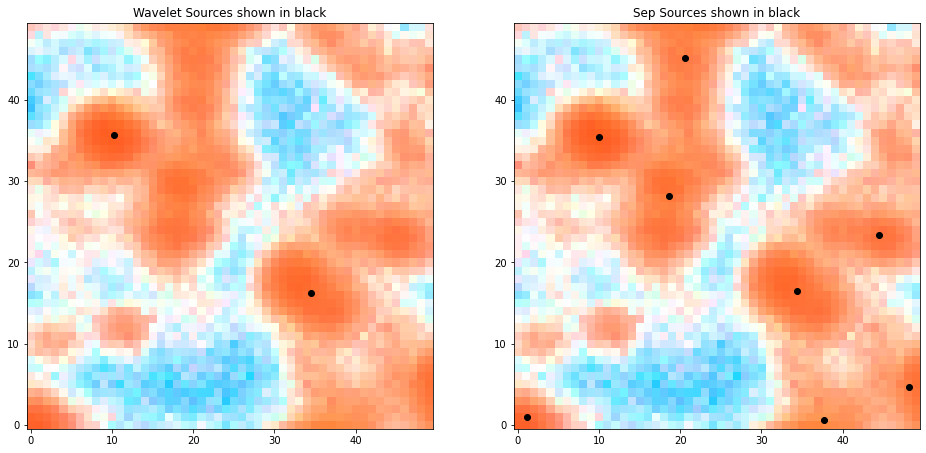

In [207]:
# Create a color mapping for the HSC image
norm_hsc = AsinhMapping(minimum=imageList.min(), stretch=50, Q=20)
#norm_hst = AsinhMapping(minimum=-1, stretch=10, Q=5)

# Get the source coordinates from the HST catalog
pixel = np.stack((catListFull['y'], catListFull['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec = observation.frame.get_sky_coord(pixel)

# Map the HSC image to RGB
img = scarlet.display.img_to_rgb(imageList, norm=norm_hsc)
# Apply Asinh to the HST data
#img_hst = scarlet.display.img_to_rgb(data_hst, norm=norm_hsc)

fig, ax = plt.subplots(1,2,figsize=(16,8))
#plt.figure(figsize=(8,4))
#plt.subplot(121)
ax[0].set_title('Wavelet Sources shown in black')
ax[0].imshow(img)
ax[0].plot(pixel[:,1],pixel[:,0], 'ok')

pixel_sep = np.stack((catListSep['y'], catListSep['x']), axis=1)
#Convert the HST coordinates to the HSC WCS
ra_dec_sep = observation.frame.get_sky_coord(pixel_sep)

ax[1].set_title('Sep Sources shown in black')
ax[1].imshow(img)
ax[1].plot(pixel_sep[:,1],pixel_sep[:,0], 'ok')
# plt.show()
# plt.subplot(122)
# plt.imshow(img_hst)
# plt.plot(pixel_hst[:,1],pixel_hst[:,0], 'xr')
# plt.show()



In [208]:
#coadd, coadd_rms = build_initialization_coadd(observation, filtered_coadd = True)

# Source initialisation
sources = [
    scarlet.PointSource(model_frame,
                           sky_coord,
                           observation)
    for sky_coord in ra_dec
]

blend = scarlet.Blend(sources, observation)



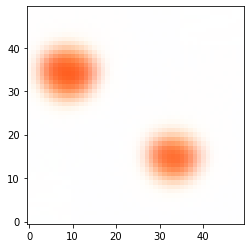

In [209]:
# stretch = 0.2
# Q = 10
# norm = AsinhMapping(minimum=imageList.min(), stretch=10, Q=20)

model = blend.get_model()
model_ = observation.render(model)
img_rgb = scarlet.display.img_to_rgb(model_, norm=norm_hsc)
plt.imshow(img_rgb)
plt.show()

CPU times: user 924 ms, sys: 4 ms, total: 928 ms
Wall time: 949 ms
scarlet ran for 56 iterations to logL = -3.412304829214571e+17


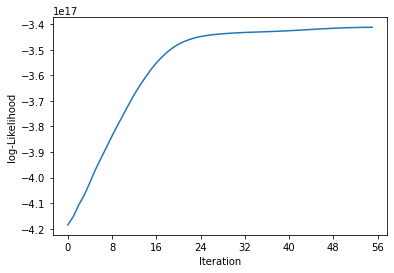

In [210]:
%time it, logL = blend.fit(200, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()


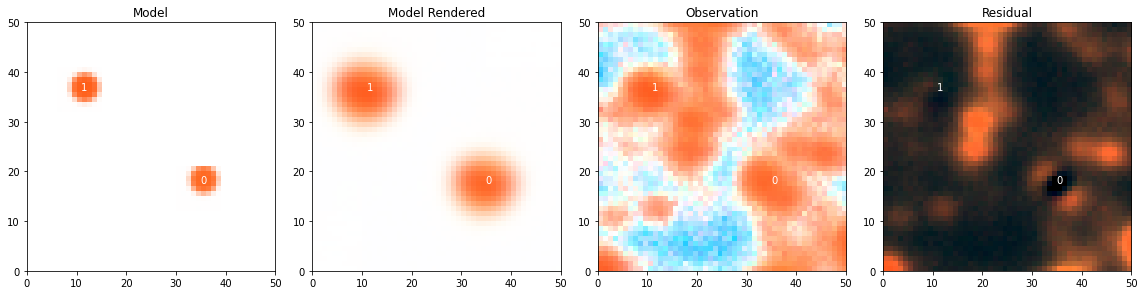

In [211]:
scarlet.display.show_scene(sources,
                           norm=norm_hsc,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()



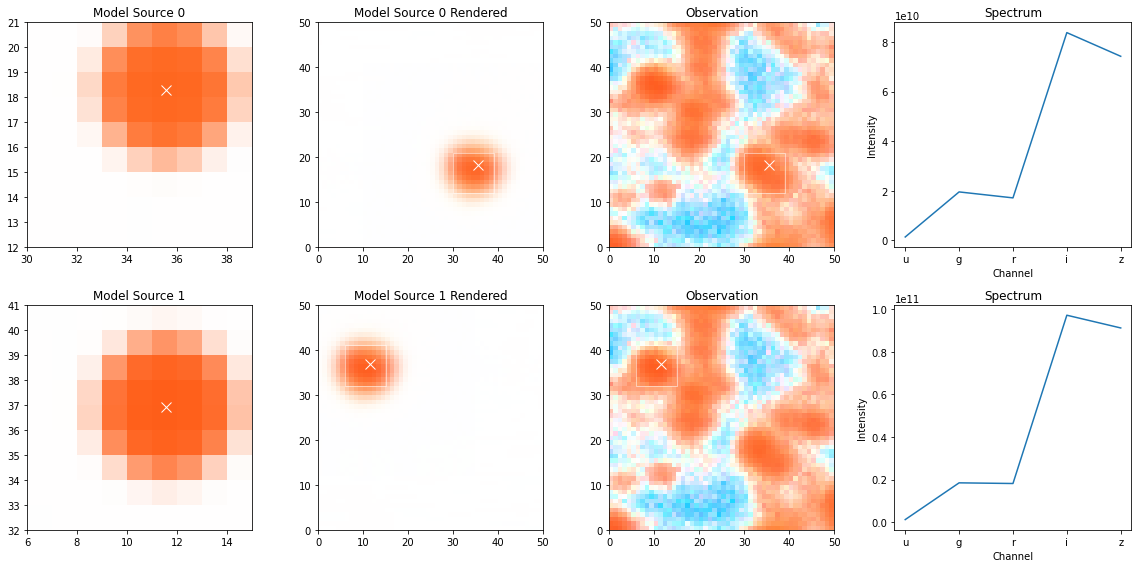

In [212]:
scarlet.display.show_sources(sources,
                             norm=norm_hsc,
                             observation=observation,
                             show_rendered=True,
                             show_observed=True,
                             add_boxes=True
                            )
plt.show()

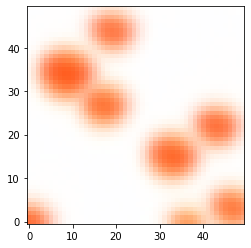

In [213]:
sources = [
    scarlet.PointSource(model_frame,
                           sky_coord,
                           observation)
    for sky_coord in ra_dec_sep
]

blend = scarlet.Blend(sources, observation)


model = blend.get_model()
model_ = observation.render(model)
img_rgb = scarlet.display.img_to_rgb(model_, norm=norm_hsc)
plt.imshow(img_rgb)
plt.show()



CPU times: user 2.02 s, sys: 12 ms, total: 2.04 s
Wall time: 2.05 s
scarlet ran for 68 iterations to logL = -1.1858888430911653e+17


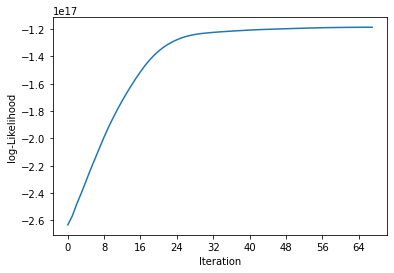

In [214]:
%time it, logL = blend.fit(200, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

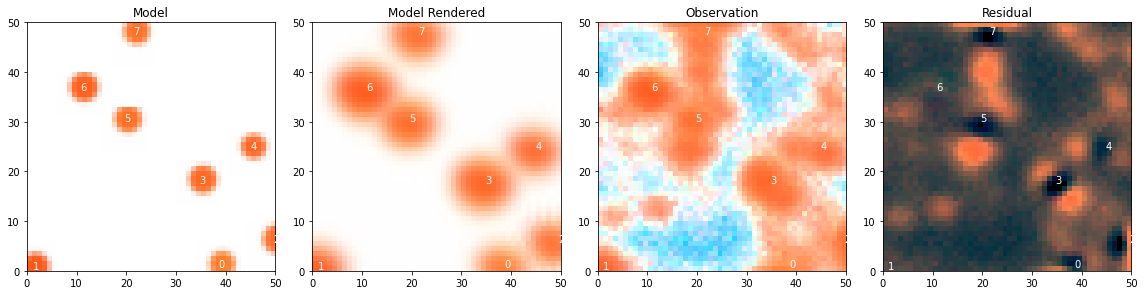

In [215]:
scarlet.display.show_scene(sources,
                           norm=norm_hsc,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()


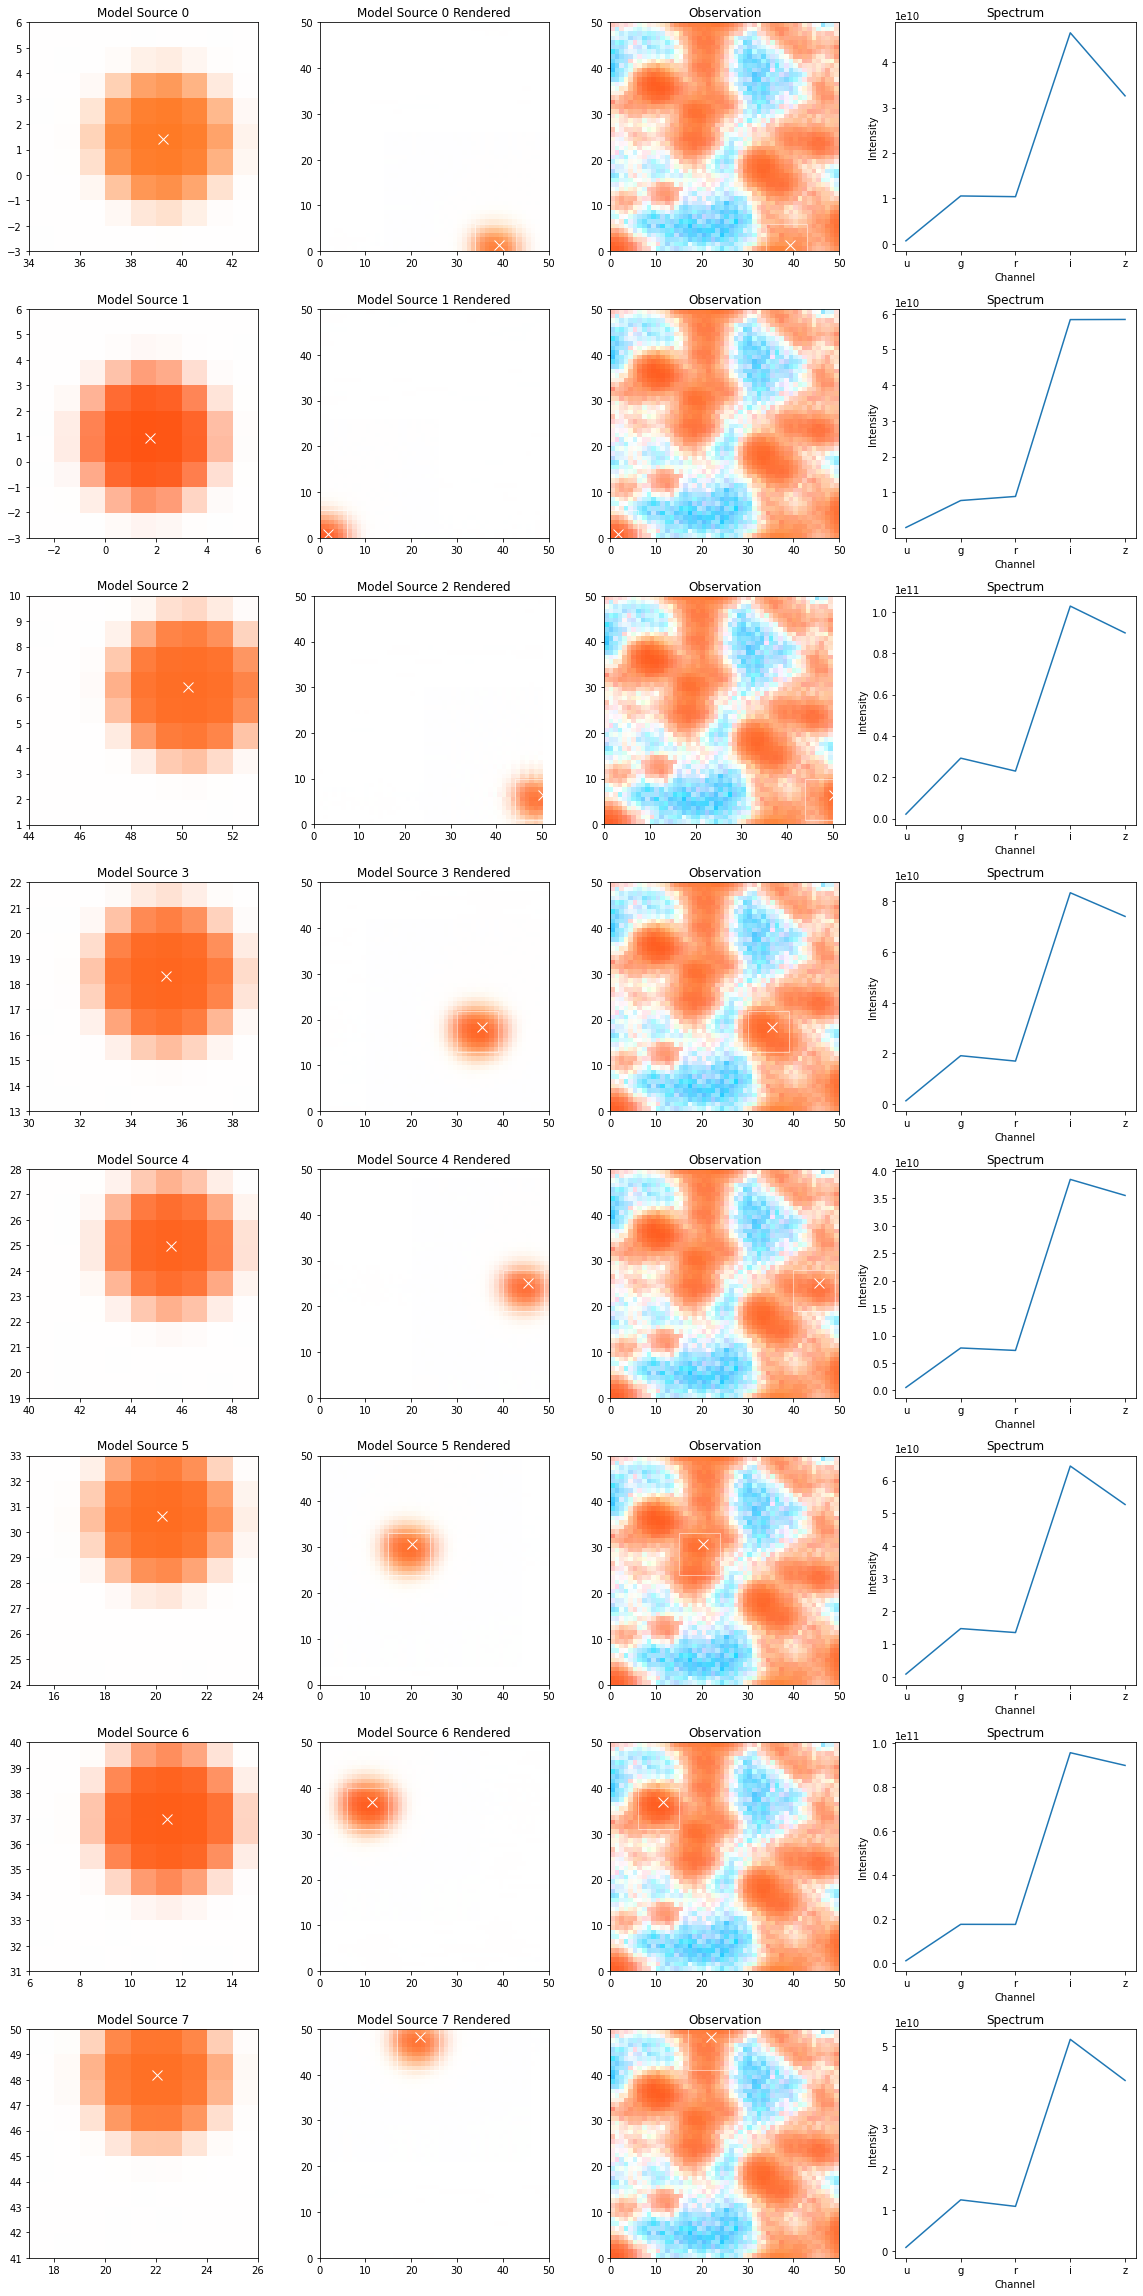

In [216]:
scarlet.display.show_sources(sources,
                             norm=norm_hsc,
                             observation=observation,
                             show_rendered=True,
                             show_observed=True,
                             add_boxes=True
                            )
plt.show()

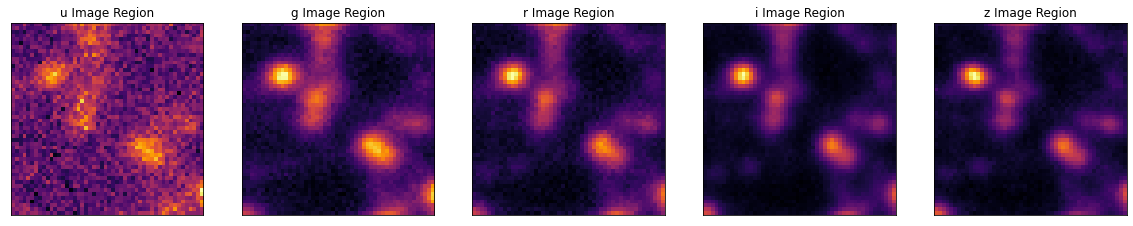

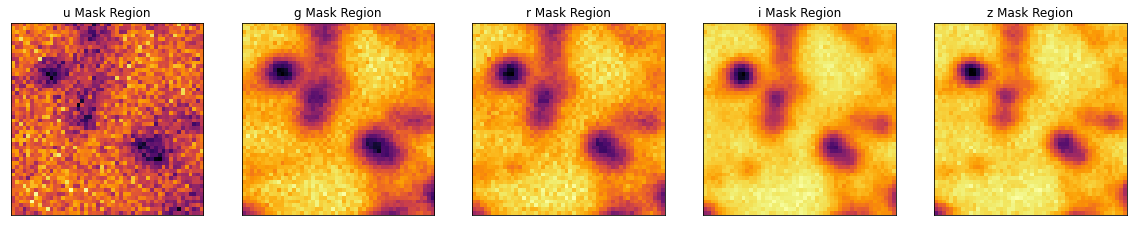

In [219]:
fig, ax = plt.subplots(1,len(imageList),figsize=(20,4))

for i,x in enumerate(imageList):
    ax[i].set_title('{} Image Region'.format(channels[i]))
    ax[i].imshow(x)#,norm=LogNorm())
    #ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    
fig, ax = plt.subplots(1,len(imageList),figsize=(20,4))
ax[int(len((imageList)-1.)/2.)].set_title('Mask Regions')

for i,x in enumerate(weigthsList):
    ax[i].set_title('{} Mask Region'.format(channels[i]))
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])
#     hdu = fits.PrimaryHDU(x)
#     hdul = fits.HDUList([hdu])
#     hdu.writeto('NGC_6569_cutout_{}.fits'.format(channels[i]))